In [1]:
import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
providers_fp = "providers_data.csv"
receivers_fp = "receivers_data.csv"
food_listings_fp = "food_listings_data.csv"
claims_fp = "claims_data.csv"

providers_df = pd.read_csv(providers_fp)
receivers_df = pd.read_csv(receivers_fp)
food_df = pd.read_csv(food_listings_fp)
claims_df = pd.read_csv(claims_fp)

In [3]:
for df in [providers_df, receivers_df, food_df, claims_df]:
    df.columns = df.columns.str.strip()

In [4]:
if 'Expiry_Date' in food_df.columns:
    food_df['Expiry_Date'] = pd.to_datetime(food_df['Expiry_Date'], errors='coerce').dt.date
if 'Timestamp' in claims_df.columns:
    claims_df['Timestamp'] = pd.to_datetime(claims_df['Timestamp'], errors='coerce')


In [5]:
if 'Quantity' in food_df.columns:
    food_df['Quantity'] = pd.to_numeric(food_df['Quantity'], errors='coerce').fillna(0).astype(int)

In [6]:
db_path = "food_waste.db"
if os.path.exists(db_path):
    os.remove(db_path)
conn = sqlite3.connect(db_path)
cur = conn.cursor()
conn.execute("PRAGMA foreign_keys = ON;")

cur.execute("""
CREATE TABLE providers (
    Provider_ID INTEGER PRIMARY KEY,
    Name TEXT,
    Type TEXT,
    Address TEXT,
    City TEXT,
    Contact TEXT
);
""")
cur.execute("""
CREATE TABLE receivers (
    Receiver_ID INTEGER PRIMARY KEY,
    Name TEXT,
    Type TEXT,
    City TEXT,
    Contact TEXT
);
""")
cur.execute("""
CREATE TABLE food_listings (
    Food_ID INTEGER PRIMARY KEY,
    Food_Name TEXT,
    Quantity INTEGER DEFAULT 0,
    Expiry_Date TEXT,
    Provider_ID INTEGER,
    Provider_Type TEXT,
    Location TEXT,
    Food_Type TEXT,
    Meal_Type TEXT,
    FOREIGN KEY (Provider_ID) REFERENCES providers(Provider_ID)
);
""")
cur.execute("""
CREATE TABLE claims (
    Claim_ID INTEGER PRIMARY KEY,
    Food_ID INTEGER,
    Receiver_ID INTEGER,
    Status TEXT,
    Timestamp TEXT,
    FOREIGN KEY (Food_ID) REFERENCES food_listings(Food_ID),
    FOREIGN KEY (Receiver_ID) REFERENCES receivers(Receiver_ID)
);
""")
conn.commit()

In [7]:
def insert_df(table, df, cols):
    data = df[cols].where(pd.notnull(df), None).values.tolist()
    placeholders = ",".join(["?"] * len(cols))
    conn.executemany(f"INSERT INTO {table} ({','.join(cols)}) VALUES ({placeholders})", data)
    conn.commit()

insert_df('providers', providers_df, ['Provider_ID','Name','Type','Address','City','Contact'])
insert_df('receivers', receivers_df, ['Receiver_ID','Name','Type','City','Contact'])
food_df['Expiry_Date'] = food_df['Expiry_Date'].astype(str).replace('NaT','')
insert_df('food_listings', food_df, ['Food_ID','Food_Name','Quantity','Expiry_Date','Provider_ID','Provider_Type','Location','Food_Type','Meal_Type'])
claims_df['Timestamp'] = claims_df['Timestamp'].astype(str).replace('NaT','')
insert_df('claims', claims_df, ['Claim_ID','Food_ID','Receiver_ID','Status','Timestamp'])

In [8]:
def run_query(title, query):
    df = pd.read_sql_query(query, conn)
    print(f"\n--- {title} ---")
    print(df)
    return df

In [9]:
# 1
run_query("Providers & Receivers per City", """
SELECT City,
       SUM(providers_count) AS Providers,
       SUM(receivers_count) AS Receivers
FROM (
    SELECT City, COUNT(*) AS providers_count, 0 AS receivers_count FROM providers GROUP BY City
    UNION ALL
    SELECT City, 0, COUNT(*) FROM receivers GROUP BY City
)
GROUP BY City
ORDER BY City;
""")



--- Providers & Receivers per City ---
                City  Providers  Receivers
0         Aaronshire          0          1
1           Adambury          1          0
2           Adamland          0          1
3          Adamsview          1          0
4         Adamsville          1          0
...              ...        ...        ...
1873       Yatesside          1          0
1874    Youngchester          1          0
1875     Zacharyview          0          1
1876    Zimmermanton          1          0
1877  Zimmermanville          1          0

[1878 rows x 3 columns]


,City,Providers,Receivers
0,Aaronshire,0,1
1,Adambury,1,0
2,Adamland,0,1
3,Adamsview,1,0
4,Adamsville,1,0
...,...,...,...
1873,Yatesside,1,0
1874,Youngchester,1,0
1875,Zacharyview,0,1
1876,Zimmermanton,1,0


In [10]:

# 2
run_query("Provider Type by Total Quantity", """
SELECT p.Type, SUM(f.Quantity) AS Total_Quantity
FROM providers p
JOIN food_listings f ON p.Provider_ID = f.Provider_ID
GROUP BY p.Type
ORDER BY Total_Quantity DESC;
""")




--- Provider Type by Total Quantity ---
               Type  Total_Quantity
0        Restaurant            6923
1       Supermarket            6696
2  Catering Service            6116
3     Grocery Store            6059


,Type,Total_Quantity
0,Restaurant,6923
1,Supermarket,6696
2,Catering Service,6116
3,Grocery Store,6059


In [11]:
# 3
sample_city = pd.read_sql_query("SELECT City FROM providers LIMIT 1;", conn).iloc[0,0]
run_query(f"Providers in {sample_city}", f"""
SELECT Name, Contact, Address FROM providers WHERE City = '{sample_city}';
""")




--- Providers in New Jessica ---
               Name          Contact  \
0  Gonzales-Cochran  +1-600-220-0480   

                                             Address  
0  74347 Christopher Extensions\nAndreamouth, OK ...  


,Name,Contact,Address
0,Gonzales-Cochran,+1-600-220-0480,"74347 Christopher Extensions\nAndreamouth, OK ..."


In [12]:


# 4
run_query("Top Receivers by Claims", """
SELECT r.Name, COUNT(c.Claim_ID) AS Claims_Count
FROM receivers r
JOIN claims c ON r.Receiver_ID = c.Receiver_ID
GROUP BY r.Name
ORDER BY Claims_Count DESC
LIMIT 10;
""")




--- Top Receivers by Claims ---
                Name  Claims_Count
0  William Frederick             5
1       Scott Hunter             5
2       Matthew Webb             5
3     Anthony Garcia             5
4    Kristine Martin             4
5   Kristina Simpson             4
6    Jennifer Nelson             4
7    Donald Caldwell             4
8     Chelsea Powell             4
9         Betty Reid             4


,Name,Claims_Count
0,William Frederick,5
1,Scott Hunter,5
2,Matthew Webb,5
3,Anthony Garcia,5
4,Kristine Martin,4
5,Kristina Simpson,4
6,Jennifer Nelson,4
7,Donald Caldwell,4
8,Chelsea Powell,4
9,Betty Reid,4


In [13]:


# 5
run_query("Total Quantity Available", "SELECT SUM(Quantity) AS Total_Quantity FROM food_listings;")




--- Total Quantity Available ---
   Total_Quantity
0           25794


,Total_Quantity
0,25794


In [14]:


# 6
run_query("Listings Count by City", """
SELECT Location AS City, COUNT(*) AS Listings_Count
FROM food_listings
GROUP BY Location
ORDER BY Listings_Count DESC;
""")




--- Listings Count by City ---
                 City  Listings_Count
0       South Kathryn               6
1           New Carol               6
2           Perezport               5
3           Jimmyberg               5
4         East Angela               5
..                ...             ...
619     Andersonmouth               1
620       Amandashire               1
621      Allenborough               1
622  Alexanderchester               1
623          Adambury               1

[624 rows x 2 columns]


,City,Listings_Count
0,South Kathryn,6
1,New Carol,6
2,Perezport,5
3,Jimmyberg,5
4,East Angela,5
...,...,...
619,Andersonmouth,1
620,Amandashire,1
621,Allenborough,1
622,Alexanderchester,1


In [15]:

# 7
run_query("Most Common Food Types", """
SELECT Food_Type, COUNT(*) AS Count_Listings
FROM food_listings
GROUP BY Food_Type
ORDER BY Count_Listings DESC;
""")




--- Most Common Food Types ---
        Food_Type  Count_Listings
0      Vegetarian             336
1           Vegan             334
2  Non-Vegetarian             330


,Food_Type,Count_Listings
0,Vegetarian,336
1,Vegan,334
2,Non-Vegetarian,330


In [16]:

# 8
run_query("Claims per Food Item", """
SELECT f.Food_Name, COUNT(c.Claim_ID) AS Claims_Count
FROM food_listings f
LEFT JOIN claims c ON f.Food_ID = c.Food_ID
GROUP BY f.Food_Name
ORDER BY Claims_Count DESC;
""")




--- Claims per Food Item ---
    Food_Name  Claims_Count
0        Rice           122
1        Soup           114
2       Dairy           110
3        Fish           108
4       Salad           106
5     Chicken           102
6       Bread            94
7       Pasta            87
8  Vegetables            86
9      Fruits            71


,Food_Name,Claims_Count
0,Rice,122
1,Soup,114
2,Dairy,110
3,Fish,108
4,Salad,106
5,Chicken,102
6,Bread,94
7,Pasta,87
8,Vegetables,86
9,Fruits,71


In [17]:




# 9
run_query("Providers by Successful Claims", """
SELECT p.Name, COUNT(c.Claim_ID) AS Successful_Claims
FROM providers p
JOIN food_listings f ON p.Provider_ID = f.Provider_ID
JOIN claims c ON f.Food_ID = c.Food_ID
WHERE LOWER(c.Status) LIKE 'completed%'
GROUP BY p.Name
ORDER BY Successful_Claims DESC
LIMIT 10;
""")




--- Providers by Successful Claims ---
                          Name  Successful_Claims
0                  Barry Group                  5
1                   Miller Inc                  4
2  Harper, Blake and Alexander                  4
3            Butler-Richardson                  4
4    Barnes, Castro and Curtis                  4
5                Rogers-Warren                  3
6                   Nelson LLC                  3
7                Moore-Flowers                  3
8                 Mckinney Ltd                  3
9              Hancock-Jackson                  3


,Name,Successful_Claims
0,Barry Group,5
1,Miller Inc,4
2,"Harper, Blake and Alexander",4
3,Butler-Richardson,4
4,"Barnes, Castro and Curtis",4
5,Rogers-Warren,3
6,Nelson LLC,3
7,Moore-Flowers,3
8,Mckinney Ltd,3
9,Hancock-Jackson,3


In [18]:


# 10
run_query("Claims Status Distribution", """
SELECT Status, COUNT(*) AS Count_Status,
       ROUND(100.0*COUNT(*)/(SELECT COUNT(*) FROM claims),2) AS Percentage
FROM claims
GROUP BY Status;
""")




--- Claims Status Distribution ---
      Status  Count_Status  Percentage
0  Cancelled           336        33.6
1  Completed           339        33.9
2    Pending           325        32.5


,Status,Count_Status,Percentage
0,Cancelled,336,33.6
1,Completed,339,33.9
2,Pending,325,32.5


In [19]:

# 11
run_query("Avg Quantity Claimed per Receiver", """
SELECT r.Name, ROUND(AVG(f.Quantity),2) AS Avg_Quantity_Claimed
FROM receivers r
JOIN claims c ON r.Receiver_ID = c.Receiver_ID
JOIN food_listings f ON c.Food_ID = f.Food_ID
GROUP BY r.Name
ORDER BY Avg_Quantity_Claimed DESC
LIMIT 10;
""")




--- Avg Quantity Claimed per Receiver ---
                 Name  Avg_Quantity_Claimed
0   Thomas Villanueva                  50.0
1        Peggy Knight                  50.0
2         Nancy Silva                  50.0
3         Nancy Jones                  50.0
4          Lisa Pitts                  50.0
5     Daniel Williams                  50.0
6  Christopher Wright                  50.0
7   Timothy Patel DVM                  49.0
8         Scott Brown                  49.0
9      Melissa Little                  49.0


,Name,Avg_Quantity_Claimed
0,Thomas Villanueva,50.0
1,Peggy Knight,50.0
2,Nancy Silva,50.0
3,Nancy Jones,50.0
4,Lisa Pitts,50.0
5,Daniel Williams,50.0
6,Christopher Wright,50.0
7,Timothy Patel DVM,49.0
8,Scott Brown,49.0
9,Melissa Little,49.0


In [20]:
# 12
run_query("Most Claimed Meal Type", """
SELECT f.Meal_Type, COUNT(c.Claim_ID) AS Claims_Count
FROM food_listings f
JOIN claims c ON f.Food_ID = c.Food_ID
GROUP BY f.Meal_Type
ORDER BY Claims_Count DESC;
""")




--- Most Claimed Meal Type ---
   Meal_Type  Claims_Count
0  Breakfast           278
1      Lunch           250
2     Snacks           240
3     Dinner           232


,Meal_Type,Claims_Count
0,Breakfast,278
1,Lunch,250
2,Snacks,240
3,Dinner,232


In [21]:
# 13
run_query("Total Quantity Donated by Provider", """
SELECT p.Name, SUM(f.Quantity) AS Total_Donated
FROM providers p
JOIN food_listings f ON p.Provider_ID = f.Provider_ID
GROUP BY p.Name
ORDER BY Total_Donated DESC;
""")



--- Total Quantity Donated by Provider ---
                                Name  Total_Donated
0                         Miller Inc            217
1                        Barry Group            179
2         Evans, Wright and Mitchell            158
3                        Smith Group            150
4                       Campbell LLC            145
..                               ...            ...
623                   Reyes and Sons              1
624                  Norris-Townsend              1
625                        Mcgee PLC              1
626  Martinez, Armstrong and Carroll              1
627                   Gonzales-Moore              1

[628 rows x 2 columns]


,Name,Total_Donated
0,Miller Inc,217
1,Barry Group,179
2,"Evans, Wright and Mitchell",158
3,Smith Group,150
4,Campbell LLC,145
...,...,...
623,Reyes and Sons,1
624,Norris-Townsend,1
625,Mcgee PLC,1
626,"Martinez, Armstrong and Carroll",1


In [22]:

# 14
run_query("Top 5 Providers by Quantity", """
SELECT p.Name, SUM(f.Quantity) AS Total_Donated
FROM providers p
JOIN food_listings f ON p.Provider_ID = f.Provider_ID
GROUP BY p.Name
ORDER BY Total_Donated DESC
LIMIT 5;
""")




--- Top 5 Providers by Quantity ---
                         Name  Total_Donated
0                  Miller Inc            217
1                 Barry Group            179
2  Evans, Wright and Mitchell            158
3                 Smith Group            150
4                Campbell LLC            145


,Name,Total_Donated
0,Miller Inc,217
1,Barry Group,179
2,"Evans, Wright and Mitchell",158
3,Smith Group,150
4,Campbell LLC,145


In [23]:
# 15
today_str = datetime.utcnow().date().isoformat()
three_days_str = (datetime.utcnow().date() + timedelta(days=3)).isoformat()
run_query("Listings Expiring in Next 3 Days", f"""
SELECT Food_Name, Quantity, Expiry_Date, Location
FROM food_listings
WHERE Expiry_Date BETWEEN '{today_str}' AND '{three_days_str}'
ORDER BY Expiry_Date;
""")



--- Listings Expiring in Next 3 Days ---
Empty DataFrame
Columns: [Food_Name, Quantity, Expiry_Date, Location]
Index: []


,Food_Name,Quantity,Expiry_Date,Location


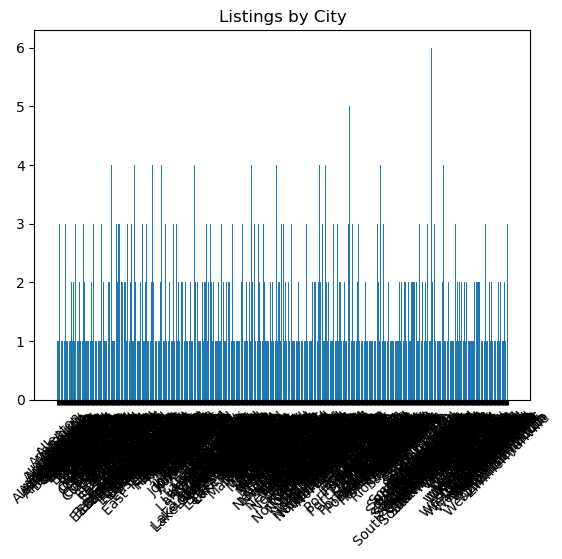

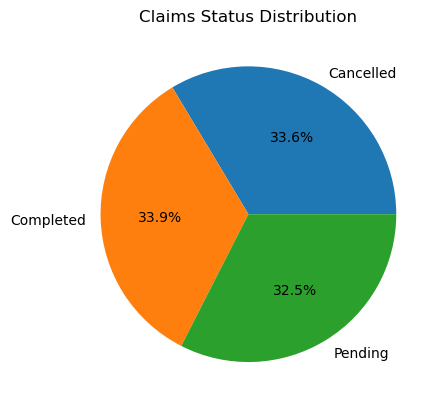


Database saved as food_waste.db


In [24]:
df_city = pd.read_sql_query("SELECT Location, COUNT(*) AS Count FROM food_listings GROUP BY Location", conn)
plt.bar(df_city['Location'], df_city['Count'])
plt.xticks(rotation=45)
plt.title("Listings by City")
plt.show()

df_status = pd.read_sql_query("SELECT Status, COUNT(*) AS Count FROM claims GROUP BY Status", conn)
plt.pie(df_status['Count'], labels=df_status['Status'], autopct='%1.1f%%')
plt.title("Claims Status Distribution")
plt.show()

conn.close()
print(f"\nDatabase saved as {db_path}")